In [ ]:
import torch
print("Pytorch version:", torch.__version__)

Pytorch version: 2.9.0+cu126


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
%pip install ipython-autotime
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.9 MB/s eta 0:00:00
time: 211 µs (started: 2026-01-06 13:33:12 +00:00)


In [ ]:
!pip install torchinfo

time: 4.63 s (started: 2026-01-06 13:33:22 +00:00)


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import os
import random
import shutil
import PIL as pil
import cv2
import matplotlib as mpl
import tqdm
from torchinfo import summary
from torchvision import datasets
from torch.utils.data import DataLoader


time: 7.72 s (started: 2026-01-06 13:33:40 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 22.9 s (started: 2026-01-06 13:33:57 +00:00)


In [ ]:
base_url = '/content/drive/MyDrive/Research'
dataset_url = '/content/drive/MyDrive/Research/Glaucoma_Splitted'

train_path = f'{dataset_url}/train'
valid_path = f'{dataset_url}/val'
test_path  = f'{dataset_url}/test'

batch_size = 4
img_height = 224
img_width = 224
num_classes = 2
class_names = ['glaucoma', 'normal']

time: 1.02 ms (started: 2026-01-06 13:34:32 +00:00)


In [ ]:
def model_summary(model: torch.nn.Module, input_size: tuple):
    return summary(
        model=model,
        input_size=input_size,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=['var_names']
    )


time: 1.74 ms (started: 2026-01-06 13:34:46 +00:00)


In [ ]:
# Train-time preprocessing + augmentation
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(
        size=(img_height, img_width),
        scale=(0.8, 1.0)
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Validation preprocessing
valid_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Test preprocessing
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

time: 1.82 ms (started: 2026-01-06 13:35:02 +00:00)


In [ ]:
# DATASETS & LOADERS
# ===============================
train_ds = datasets.ImageFolder(root=train_path, transform=train_transform)
valid_ds = datasets.ImageFolder(root=valid_path, transform=valid_transform)
test_ds  = datasets.ImageFolder(root=test_path,  transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0)

time: 8.49 s (started: 2026-01-06 13:35:19 +00:00)


In [ ]:
model = torchvision.models.vit_b_16(weights="DEFAULT")

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Custom classifier
num_features = 768
custom_classifier = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, num_classes)
)

model.heads = custom_classifier

# Model summary
model_summary(
    model=model,
    input_size=(4, 3, 224, 224)
)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 201MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [4, 3, 224, 224]     [4, 2]               768                  Partial
├─Conv2d (conv_proj)                                         [4, 3, 224, 224]     [4, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [4, 197, 768]        [4, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [4, 197, 768]        [4, 197, 768]        --                   --
│    └─Sequential (layers)                                   [4, 197, 768]        [4, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [4, 197, 768]        [4, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [4, 197, 768]        [4, 1

time: 4.4 s (started: 2026-01-06 13:35:40 +00:00)


In [ ]:
params_to_train = model.heads.parameters()
model = model.to(device)

learning_rate = 0.00001
epochs = 30

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_train, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

time: 4.92 ms (started: 2026-01-06 13:36:02 +00:00)


In [ ]:
filepath = f'{base_url}/Results/vit_b_16/model_preprocess1.pth'
print(os.path.exists(filepath))

False
time: 434 ms (started: 2026-01-06 13:36:18 +00:00)


In [ ]:
def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(data_loader)
    accuracy = correct / total
    return loss, accuracy

time: 1.34 ms (started: 2026-01-06 13:36:34 +00:00)


In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        val_loss, val_accuracy = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(
            f"Epoch {epoch + 1}/{epochs}, "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
        )

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            torch.save(model.state_dict(), filepath)
            print(f"Model weights saved to {filepath}")
            best_val_loss = val_loss

    return train_losses, val_losses, train_accuracies, val_accuracies


time: 1.7 ms (started: 2026-01-06 13:36:51 +00:00)


In [ ]:
train_losses, val_losses, train_acc, val_acc = train(
    model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs
)


Epoch 1/30, Train Loss: 0.5194, Train Accuracy: 0.7801, Val Loss: 0.5093, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/vit_b_16/model_preprocess1.pth
Epoch 2/30, Train Loss: 0.4947, Train Accuracy: 0.7801, Val Loss: 0.4955, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/vit_b_16/model_preprocess1.pth
Epoch 3/30, Train Loss: 0.4857, Train Accuracy: 0.7812, Val Loss: 0.4900, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/vit_b_16/model_preprocess1.pth
Epoch 4/30, Train Loss: 0.4743, Train Accuracy: 0.7830, Val Loss: 0.4837, Val Accuracy: 0.7802
Model weights saved to /content/drive/MyDrive/Research/Results/vit_b_16/model_preprocess1.pth
Epoch 5/30, Train Loss: 0.4707, Train Accuracy: 0.7853, Val Loss: 0.4830, Val Accuracy: 0.7882
Model weights saved to /content/drive/MyDrive/Research/Results/vit_b_16/model_preprocess1.pth
Epoch 6/30, Train Loss: 0.4631, Train Accuracy: 0.7865,

In [ ]:
def plot_loss_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy_curve(train_acc, val_acc):
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

time: 919 µs (started: 2026-01-06 16:13:38 +00:00)


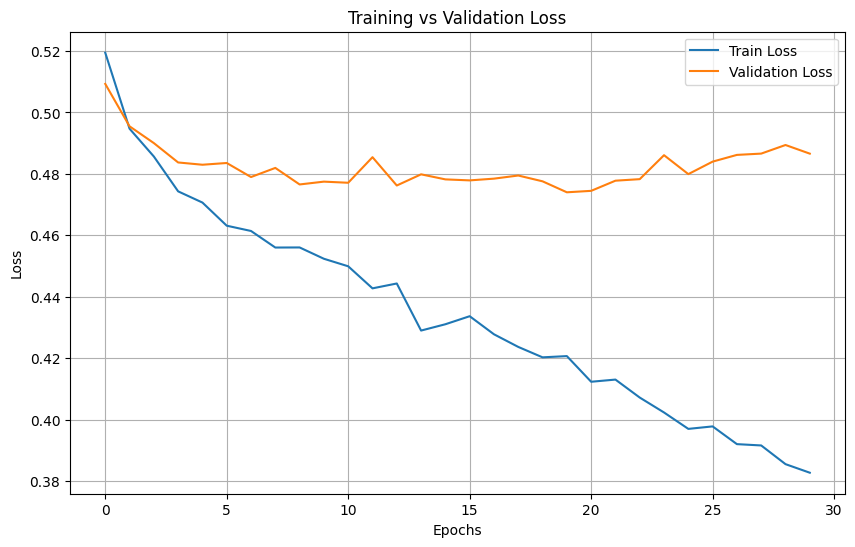

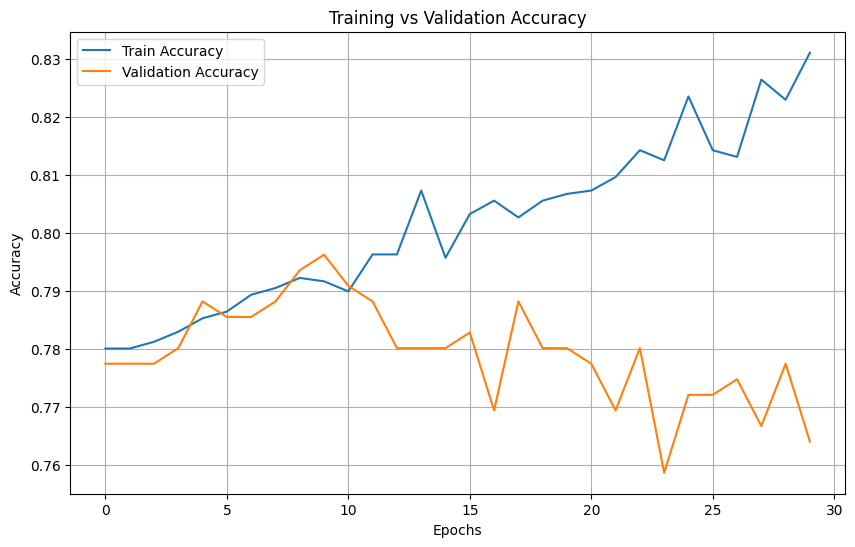

time: 438 ms (started: 2026-01-06 16:13:41 +00:00)


In [ ]:
plot_loss_curve(train_losses, val_losses)
plot_accuracy_curve(train_acc, val_acc)

In [ ]:
model.load_state_dict(torch.load(filepath))
model.to(device)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

time: 950 ms (started: 2026-01-06 16:14:07 +00:00)


In [ ]:
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4847, Test Accuracy: 0.7649
time: 3min 16s (started: 2026-01-06 16:14:12 +00:00)


In [ ]:
train_loss, train_accuracy = evaluate(model, train_loader, criterion)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

Train Loss: 0.4084, Train Accuracy: 0.8142
time: 3min 52s (started: 2026-01-06 16:17:37 +00:00)


In [ ]:
val_loss, val_accuracy = evaluate(model, valid_loader, criterion)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Validation Loss: 0.4740, Validation Accuracy: 0.7802
time: 49.5 s (started: 2026-01-06 16:21:35 +00:00)


In [ ]:
def plot_confusion_matrix(model, dataloader, class_names, title="Confusion Matrix"):
    model.eval()
    all_actual = []
    all_predicted = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_actual.extend(labels.cpu().numpy())
            all_predicted.extend(preds.cpu().numpy())

    all_actual = np.array(all_actual)
    all_predicted = np.array(all_predicted)

    cm = confusion_matrix(all_actual, all_predicted)
    print(f"\n{title}:\n", cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

    return cm

time: 1.13 ms (started: 2026-01-06 16:22:29 +00:00)



Test Confusion Matrix:
 [[  7  74]
 [ 13 276]]


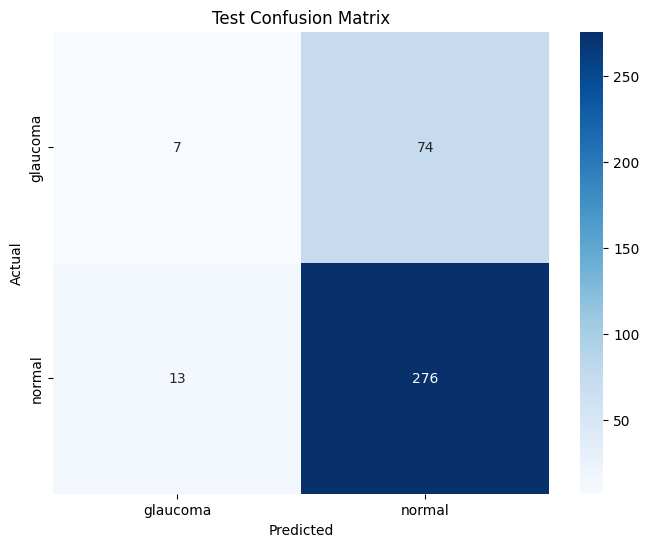

array([[  7,  74],
       [ 13, 276]])

time: 49.3 s (started: 2026-01-06 16:22:32 +00:00)


In [ ]:
plot_confusion_matrix(model, test_loader, class_names, title="Test Confusion Matrix")

In [ ]:
def plot_roc_curve(model, test_loader, class_names):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1)  # convert logits → probabilities

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())   # shape (batch,2)

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # ---- Manual 2-column binarize ----
    y_true_bin = np.zeros((len(y_true), len(class_names)))
    for idx, lab in enumerate(y_true):
        y_true_bin[idx, lab] = 1
    # ----------------------------------

    plt.figure(figsize=(10, 8))

    for i, name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)

        print(f"Class {name} ROC AUC: {roc_auc:.3f}")
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (vit_b_16)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

time: 6.54 ms (started: 2026-01-06 16:31:01 +00:00)


Class glaucoma ROC AUC: 0.689
Class normal ROC AUC: 0.689


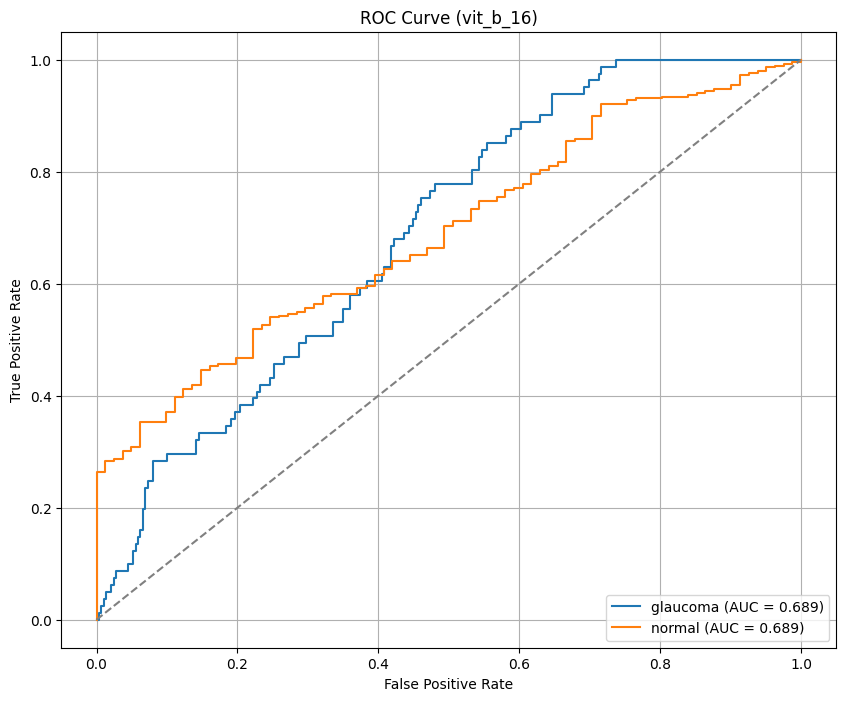

time: 49.4 s (started: 2026-01-06 16:31:19 +00:00)


In [ ]:
plot_roc_curve(model, test_loader, class_names)